# Análisis exploratorio del Ultra Marathon Transvulcania

Situada en la bucólica y agreste isla de La Palma, conocida como la isla bonita de las Canarias, la Transvulcania tiene una personalidad muy marcada, con 73 kilómetros de recorrido entre volcanes, bosques y playas de arena negra. Originariamente, este sendero fue la principal ruta de trashumancia de ganadería de La Palma y servía para comunicar las localidades más alejadas entre si.

### Librerías para el EDA

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import pearsonr

### Exploración inicial del dataset completo

El dataset incluye un total de 7.461.226 registros de carreras de ultramaratón con 1.641.168 atletas únicos, registrados en carreras de todo el mundo entre 1798 y 2022. Puede consultarse y descargarse [aquí](https://www.kaggle.com/datasets/aiaiaidavid/the-big-dataset-of-ultra-marathon-running?select=TWO_CENTURIES_OF_UM_RACES.csv).

In [2]:
# Cargar el conjunto de datos
df = pd.read_csv(
    "ultra-marathon-dataset/TWO_CENTURIES_OF_UM_RACES.csv",
    dtype={"Athlete age category": str},
    low_memory=False  # Prevenir advertencias de tipo de datos
)
df.head(5)

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4


In [3]:
# Verificar la forma del DataFrame
df.shape

(7461195, 13)

In [4]:
# Verificar los tipos de datos
df.dtypes

Year of event                  int64
Event dates                   object
Event name                    object
Event distance/length         object
Event number of finishers      int64
Athlete performance           object
Athlete club                  object
Athlete country               object
Athlete year of birth        float64
Athlete gender                object
Athlete age category          object
Athlete average speed         object
Athlete ID                     int64
dtype: object

In [5]:

# Filtrar el DataFrame para incluir solo las filas donde "Event name" contiene "(ESP)" y contar la cantidad de registros
df_esp = df[df["Event name"].str.contains(r"\(ESP\)", na=False, regex=True)]

print(f"Cantidad de registros: {len(df_esp)}")

Cantidad de registros: 233725


In [6]:
# Filtrar el DataFrame para incluir solo las filas donde "Event name" contiene "Transvulcania" y contar la cantidad de registros
transvulcania = df_esp[df_esp["Event name"].str.contains("Transvulcania", na=False, case=False)]

print(f"Cantidad de registros para Transvulcania: {len(transvulcania)}")

Cantidad de registros para Transvulcania: 10493


### Exploración inicial y limpieza de los datos de Transvulcania

Antes de iniciar el EDA, se realiza una pequeña exploración de los datos para determinar si existen nulos y, en caso afirmativo, tomar una decisión sobre cómo tratarlos. 

In [7]:
transvulcania.head(5)

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
303564,2018,12.05.2018,Transvulcania 2018 (ESP),73km,1368,7:37:26 h,Chemotuga,ESP,1983.0,M,M23,9.575,129630
303565,2018,12.05.2018,Transvulcania 2018 (ESP),73km,1368,7:38:22 h,Adidas Terrex,RUS,1991.0,M,M23,9.556,60760
303566,2018,12.05.2018,Transvulcania 2018 (ESP),73km,1368,7:42:49 h,Hoka ONE ONE - Terre d...,FRA,1990.0,M,M23,9.464,2598
303567,2018,12.05.2018,Transvulcania 2018 (ESP),73km,1368,7:44:26 h,Team Hoka ONE ONE,ITA,1977.0,M,M40,9.431,178385
303568,2018,12.05.2018,Transvulcania 2018 (ESP),73km,1368,7:46:53 h,Asics,FRA,1988.0,M,M23,9.381,129631


In [8]:
# Cantidad de valores nulos por columna

print("\nValores nulos por columna:")
print(transvulcania.isnull().sum())


Valores nulos por columna:
Year of event                   0
Event dates                     0
Event name                      0
Event distance/length           0
Event number of finishers       0
Athlete performance             0
Athlete club                 4874
Athlete country                 0
Athlete year of birth        1843
Athlete gender                  0
Athlete age category         1835
Athlete average speed           0
Athlete ID                      0
dtype: int64


Antes de decidir qué hacer con los valores nulos del "Year of birth" y "Age category", se pasa a explorar la distribución de edades para averiguar si existen outliers que deberían tenerse en cuenta.

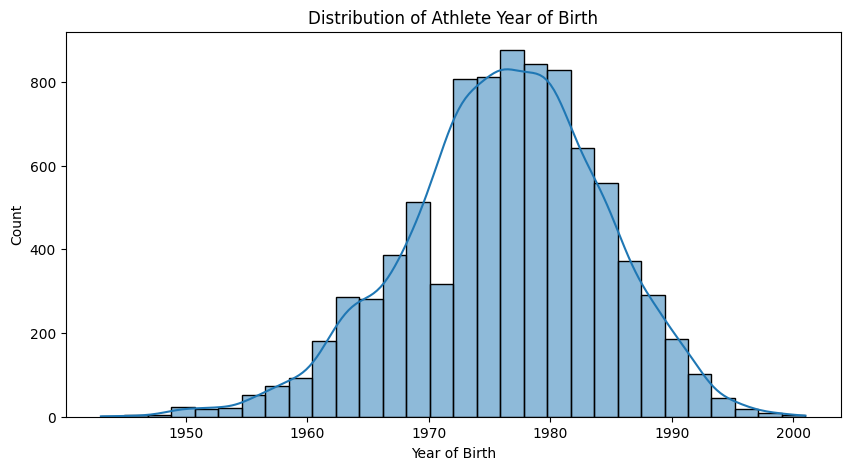

In [9]:
# Histograma de los años de nacimiento de los atletas

plt.figure(figsize=(10, 5))
sns.histplot(transvulcania["Athlete year of birth"].dropna(), bins=30, kde=True)
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.title("Distribution of Athlete Year of Birth")
plt.show()

**Distribución de los datos:**

El histograma muestra una distribución bastante normal con un pico entre 1970 y 1980. Hay pocos valores extremos antes de 1950 y después del 2000.

In [10]:
# Estadísticas básicas de "Athlete year of birth"
transvulcania["Athlete year of birth"].describe()

count    8650.000000
mean     1976.166705
std         8.113013
min      1943.000000
25%      1971.000000
50%      1976.000000
75%      1982.000000
max      2001.000000
Name: Athlete year of birth, dtype: float64

In [11]:
# Usar una imputación aleatoria dentro del IQR (1971-1982) para rellenar los valores nulos de "Athlete year of birth"

np.random.seed(42) 
random_years = np.random.randint(1971, 1983, size=transvulcania["Athlete year of birth"].isna().sum())
transvulcania.loc[transvulcania["Athlete year of birth"].isna(), "Athlete year of birth"] = random_years

In [12]:
age_categories = transvulcania["Athlete age category"].unique()
print("Categorías de edad:", age_categories)

Categorías de edad: ['M23' 'M40' 'M35' 'MU23' 'W35' 'W23' nan 'M45' 'M50' 'W40' 'M55' 'W50'
 'W45' 'M65' 'M60' 'W55' 'W60' 'M70' 'WU23']


Parece que las categorías de edad siguen un formato basado en género y rango de edad:

- "M" y "W" indican el género:
    - M → Male (Hombres)
    - W → Women (Mujeres)

- Los números indican grupos de edad:
    - 23, 35, 40, 45, 50, etc. → Probablemente indican la edad mínima de cada categoría.
    - MU23 / WU23 → "Under 23" (Menores de 23 años).

In [13]:
clubs = transvulcania["Athlete club"].unique()
print("Clubs:", clubs)

Clubs: ['Chemotuga' 'Adidas Terrex' 'Hoka ONE ONE - Terre d...' ... 'Pa Que Team'
 'Runners Point Ulm' 'Ud Makina']


In [ ]:
# Lista de términos comunes que indican que no están afiliados
non_affiliated_terms = ["Unaffiliated", "No club", "Self-supported", "Independent", "None", "No affiliation", "N/A", "None", "Independiente", "Sin club", "Sin afiliación", "Sin equipo", "Sin club", "No afiliado", "No club"]

# Filtrar los clubs para encontrar coincidencias con esos términos
non_affiliated_clubs = transvulcania[transvulcania["Athlete club"].str.contains('|'.join(non_affiliated_terms), case=False, na=False)]

# Mostrar los resultados
print("Clubs no afiliados:")
print(non_affiliated_clubs["Athlete club"].unique())


Clubs no afiliados:
['Independientemente' 'SIN Equipo' 'NO (Independiente)'
 'NO (Independente)']


In [26]:
# Reemplazar todos esos términos por "Unaffiliated"
transvulcania.loc[:,"Athlete club"] = transvulcania["Athlete club"].replace(non_affiliated_terms, "Unaffiliated")

In [27]:
# Reemplazar los valores nulos en "Athlete club" por "Unaffiliated"
transvulcania.loc[:, "Athlete club"] = transvulcania["Athlete club"].fillna("Unaffiliated")

In [28]:
print("\nValores nulos por columna:")
print(transvulcania.isnull().sum())


Valores nulos por columna:
Year of event                   0
Event dates                     0
Event name                      0
Event distance/length           0
Event number of finishers       0
Athlete performance             0
Athlete club                    0
Athlete country                 0
Athlete year of birth           0
Athlete gender                  0
Athlete age category         1835
Athlete average speed           0
Athlete ID                      0
dtype: int64


In [ ]:
# Rellenar los nulos en "Athlete age category" utilizando el "Athlete year of birth" "Athlete gender" y "Year of event"

def calculate_age_category(row):
    if pd.isna(row["Athlete age category"]):
        age = row["Year of event"] - row["Athlete year of birth"]
        # if age < 20:
        #     return "Junior"
        # elif 20 <= age < 40:
        #     return "Senior"
        # else:
        #     return "Master"
    else:
        return row["Athlete age category"]

transvulcania["Athlete age category"] = transvulcania.apply(calculate_age_category, axis=1)


In [ ]:
# Verificar nuevamente los valores nulos
print("\nValores nulos por columna:")
transvulcania.isnull().sum()

In [16]:
# Años disponibles en los datos

available_years = sorted(transvulcania["Year of event"].unique().tolist())
print("Available years in order:", available_years)

Available years in order: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [17]:
# Distribución de género

print("\nCantidad de hombres y mujeres:")
print(transvulcania["Athlete gender"].value_counts())


Cantidad de hombres y mujeres:
Athlete gender
M    9470
F    1023
Name: count, dtype: int64
